### Test Parseval K-SVD
#### Part1: Learning a K-SVD dictionary for the initial dictionary for Parseval K-SVD

Iteration   2   max error norm is: 1.6245e-12
Iteration   3   max error norm is: 2.8921e-12
Iteration   4   max error norm is: 2.1442e-12
Iteration   5   max error norm is: 1.8099e-12
Iteration   6   max error norm is: 1.2815e-12
Iteration   7   max error norm is: 1.6471e-12
Iteration   8   max error norm is: 1.5179e-12
Iteration   9   max error norm is: 3.6021e-12
Iteration   10   max error norm is: 2.3856e-12
Iteration   11   max error norm is: 3.0613e-12
Iteration   12   max error norm is: 2.983e-12
Iteration   13   max error norm is: 2.243e-12
Iteration   14   max error norm is: 2.6622e-12
Iteration   15   max error norm is: 2.3476e-12
Iteration   16   max error norm is: 2.6202e-12
Iteration   17   max error norm is: 2.3163e-12
Iteration   18   max error norm is: 2.2614e-12
Iteration   19   max error norm is: 1.8732e-12
Iteration   20   max error norm is: 5.8289e-12
Iteration   21   max error norm is: 1.9566e-12
Iteration   22   max error norm is: 2.1851e-12
Iteration   23   max er

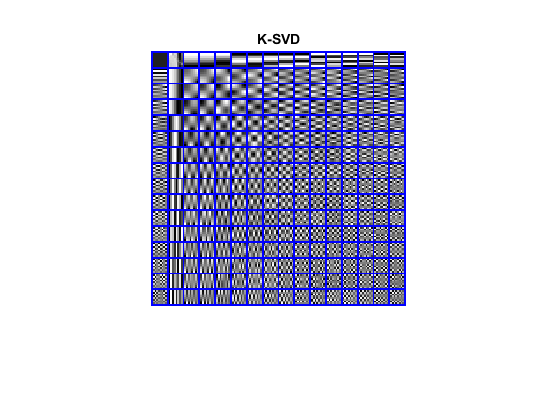

In [1]:
Im = imread('boat256.png');
Im = double(Im);

Im_block_col = im2col(Im, [8,8], 'distinct'); %Im block
Im_block_col_mean = mean(Im_block_col);
Y = Im_block_col - Im_block_col_mean; % E(Yi) = 0, for all i

%K-SVD

%create overcomplete DCT frame
Pn = 16 ;
DCT=zeros(8,Pn);
for k=0:1:Pn-1,
    V=cos([0:1:7]'*k*pi/Pn);
    if k>0, V=V-mean(V); end;
    DCT(:,k+1)=V/norm(V);
end;
DCT=kron(DCT,DCT);

param.K = 256;
param.numIteration = 30;
param.InitializationMethod =  'GivenMatrix';
param.initialDictionary = DCT;
param.displayProgress = 1;
param.preserveDCAtom = 1;
param.L = 64;
param.errorFlag = 0;
param.errorGoal = 1.0e-8;
[D_svd, output] = KSVD(Y, param);
X = full(output.CoefMatrix);

KsvdIm = plot_8by8_frame(D_svd);
figure;
imshow(KsvdIm); title('K-SVD'); %show D_svd element in image

#### Part2: Learning the Parseval K-SVD

Iteration = 1
L=1.84e+08  , obj_rep=2.697e+06 , obj_total=3.598e+06 , con1=70.2      , con2=269.1     
Iteration = 2
L=2.791e+08 , obj_rep=1.3e+06   , obj_total=3.982e+06 , con1=285.1     , con2=124.5     
Iteration = 3
L=-6.437e+07, obj_rep=4.017e+06 , obj_total=1.014e+07 , con1=390.5     , con2=653.8     
Iteration = 4
L=1.364e+08 , obj_rep=1.136e+07 , obj_total=9.322e+06 , con1=246.4     , con2=556.1     
Iteration = 5
L=-5.023e+07, obj_rep=9.626e+06 , obj_total=1.159e+07 , con1=123.1     , con2=294.2     
Iteration = 6
L=-3.387e+07, obj_rep=1.082e+07 , obj_total=1.049e+07 , con1=69.58     , con2=450.5     
Iteration = 7
L=5.368e+07 , obj_rep=8.127e+06 , obj_total=6.938e+06 , con1=63.6      , con2=314.5     
Iteration = 8
L=1.052e+08 , obj_rep=6.579e+06 , obj_total=5.476e+06 , con1=89.98     , con2=261       
Iteration = 9
L=8.274e+07 , obj_rep=6.012e+06 , obj_total=6.259e+06 , con1=40.23     , con2=412.7     
Iteration = 10
L=7.043e+07 , obj_rep=6.525e+06 , obj_total=6.777e+06 , co

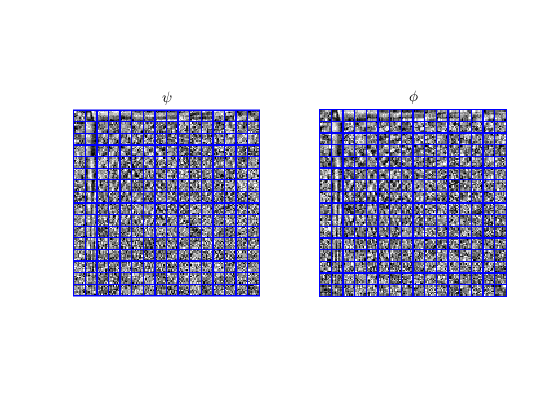

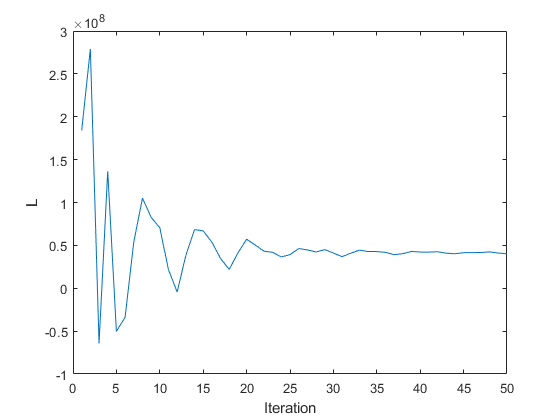

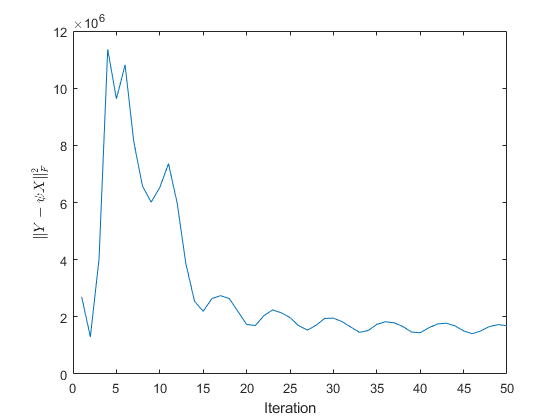

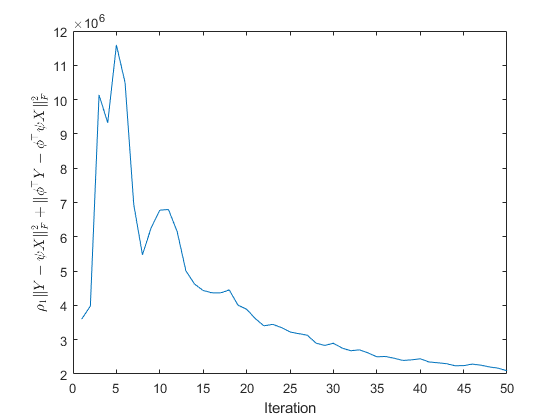

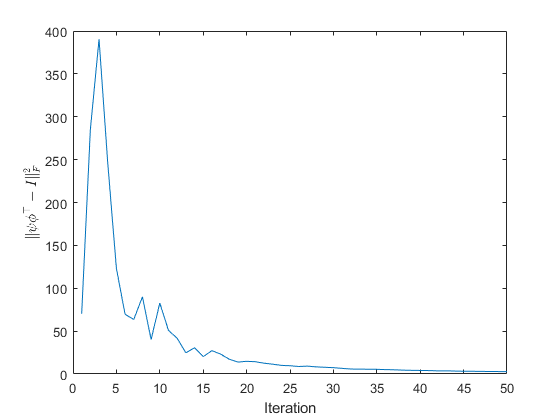

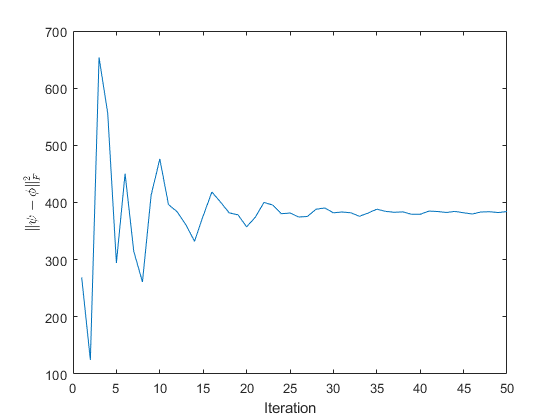

In [2]:
Psi0 = D_svd;
Phi0 = D_svd + randn(size(D_svd, 1), size(D_svd, 2));
X0 = X;
maxIter = 50;
t = 1.0e-10;
rho = [0.1, 1.0e+8, 1.0e+8];
IsRecord = true;
ShowDetail = true;

[Psi, Phi, X, Record] = ParsevalKSVD(Y, Psi0, Phi0, X0, maxIter, t, rho, IsRecord, ShowDetail);

PsiIm = plot_8by8_frame(Psi); 
PhiIm = plot_8by8_frame(Phi);
figure;
subplot(1, 2, 1); imshow(PsiIm); title('$\psi$','Interpreter','latex');
subplot(1, 2, 2); imshow(PhiIm); title('$\phi$','Interpreter','latex');

%Displaying the curve for the convergent behavior
figure;
plot(Record.augLag); xlabel('Iteration'); ylabel('L');

figure;
plot(Record.obj_rep); xlabel('Iteration'); ylabel('$\| Y - \psi X \|_F^2$', 'Interpreter','latex');

figure;
plot(Record.obj_total); xlabel('Iteration'); ylabel('$\rho_1 \| Y - \psi X \|_F^2 + \| \phi^\top Y -  \phi^\top \psi X \|_F^2$', 'Interpreter','latex');

figure;
plot(Record.con1); xlabel('Iteration'); ylabel('$\| \psi \phi^\top - I \|_F^2$', 'Interpreter','latex');

figure;
plot(Record.con2); xlabel('Iteration'); ylabel('$\| \psi - \phi \|_F^2$', 'Interpreter','latex');